In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [ ]:
def array_to_dist(dataset, feature_name, label, step):
    # 左闭右开
    if dataset is None:
        return []
    
    min_val = min(dataset[feature_name])
    max_val = max(dataset[feature_name]) 
    
    #print('feature:{},min:{}, max:{}'.format(feature_name, min_val, max_val))
    
    #print('min:{}, max:{}'.format(min_val, max_val))
    val = np.linspace(min_val, max_val, num=step+1)
    val = val.tolist()
    #print('val:{}'.format(val))
    
    dist=[]
    deal_data = dataset.loc[dataset['label']==label]
    if deal_data is None:
        return []
    sum_val = 0
    for i in range (step):
       # print('i:{},i+1:{}'.format(val[i], val[i+1]))
        x = deal_data.loc[(deal_data[feature_name]>=val[i]) & (deal_data[feature_name]<val[i+1])]
        sum_val = sum_val + len(x)
        val_size = len(x)
        dist.append(val_size)
    
    
    for i, val in enumerate(dist):
        if sum_val == 0:
            break
        dist[i] = dist[i]/sum_val
        if dist[i] == 0:
            dist[i] = 0.000001
    return dist
    

def kl_divergence(feature_name, dataset):
    '''
    计算feature_name对应的kl散度
    feature_name:特征名称
    dataset 数据集合
    面临一个问题，normal和disease两个数据长度不一致，需要对齐
    就算长度对齐也不对，需要进行分桶，计算好分布
    '''
   # neg = array_to_dist(dataset, feature_name, 0, 20)
    #pos = array_to_dist(dataset, feature_name, 1, 20)
    
    #print('neg:{},pos:{}'.format(neg, pos))
    '''
    这里使用numpy.histogram来代替之前自己写的函数，看看速度会提升不
    '''
    neg_feature_data = dataset[dataset['label'] == 0][feature_name] # 负样本数据
    pos_feature_data = dataset[dataset['label'] == 1][feature_name] # 正样本数据
    
    min_value = pos_feature_data.min() if neg_feature_data.min() > pos_feature_data.min() else neg_feature_data.min()
    max_value = neg_feature_data.max() if neg_feature_data.max() > pos_feature_data.max() else pos_feature_data.max()
    neg_hist, neg_bin = np.histogram(neg_feature_data, bins = 10, range=(min_value, max_value), density = True)
    pos_hist, pos_bin = np.histogram(pos_feature_data, bins = 10, range=(min_value, max_value), density = True)
    pos_hist[pos_hist == 0] = 1e-7
    neg_hist[neg_hist == 0] = 1e-7
    return entropy(neg_hist, pos_hist, base = 2)

# 获取所有df的
def get_all_kl_divergence(df):
    features =[]
    feature_kl = []
    size = len(df.columns)
    i = 0
    for feature in df.columns:
        if feature == 'label':
            continue
        features.append(feature)
        feature_kl.append(kl_divergence(feature, df))
        i = i + 1
        print('process:{}'.format(i))
    kl_feature_dataset = pd.DataFrame()
    kl_feature_dataset['feature_name'] = features
    kl_feature_dataset['kl_divergence'] = feature_kl
    final = kl_feature_dataset.sort_values('kl_divergence', ascending=False)
    return final

In [ ]:
def array_to_hist(arr):
    # 数组生成hist

In [ ]:
df = pd.read_csv('final_train_v4.csv', index_col = 0)
#normal_df = df[df['label'] == 0]

#disease_df = df[df['label'] == 1].sample(n = 60)

#df1 = normal_df.append(disease_df)

dd = get_all_kl_divergence(df)

In [ ]:
df['CD5L']

In [ ]:
dd.head(30)

In [ ]:
def plot_train(feature_name, dataset):
    '''
     feature_name : 特征名称
     dataset: 训练集合的dataFrame的全集
    '''
    if  dataset is None:
        return
    if feature_name is None:
        return
    # 获取最后正样本和负样本两种数据的差异
    #ax.set_title('{}患病和正常组的数据分布图'.format(feature_name))
    #f, ax= plt.subplots()
    g = sns.displot(dataset, x=feature_name, kind='kde', hue='label', fill=True, rug=True)
    #g.set_axis_labels('{}'.format(feature_name))
    #g.set_titles('ontrol group and disease group PDF',)
    #g.set_ylabels("control group and disease group PDF")
    g.ax.set_title(u'{} disease group and control group PDF'.format(feature_name))
    #g.savefig("{}.png".format(feature_name))
    #sns.displot(disease_data,kind='kde')

In [ ]:
plot_train('FXYD1', df1)

In [ ]:
choosed_features = dd[dd['kl_divergence'] > 3].reset_index(drop = True)
choosed_features

In [ ]:
len(choosed_features)

In [ ]:
choosed_features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from datetime import datetime
from tensorflow import keras

global train, test, train_ds, test_ds
def df_to_dataset(dataframe, shuffle=True, batch_size=20):
  dataframe1 = dataframe.copy()
  labels = dataframe1.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe1), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe1))
  ds = ds.batch(batch_size)
  return ds

# 定义一个函数，输入数据，然后将列作为feature_column 然后构建lr模型来看哪个特征重要
def train_model(data):
    global train, test, train_ds, test_ds
    if data is None:
        return None
    if len(data.columns) == 0:
        return None
    feature_columns = []
    for feature in data.columns:
        if feature == 'label':
            continue
        feature_columns.append(tf.feature_column.numeric_column(feature))
    
    # 生成训练数据
    batch_size=20
    train, test = train_test_split(data, test_size=0.2)
    train_ds = df_to_dataset(train, batch_size=batch_size)
    test_ds = df_to_dataset(test, batch_size=batch_size)
    
    model = tf.keras.Sequential([
          tf.keras.layers.DenseFeatures(feature_columns),
          #tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'Recall', 'Precision'])
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    model.fit(train_ds,
          validation_data = test_ds,
          epochs = 100,
          callbacks = [tensorboard_callback])
    return model
    

In [ ]:
#df_final = df[choosed_features['feature_name'] + ['label']]
#df_final['label'] = df['label']
#choosed_features['feature_name'].values.insert(['label'])
#choosed_features['feature_name'].append('label')
index_columns = np.append(choosed_features['feature_name'].values, ['label'])
df_final = df[index_columns]

In [ ]:
df_final.head(10)

In [ ]:
df_t2 = shuffle(df_final)
train_model(df_t2)

In [ ]:
df = pd.read_csv('final_train_v4.csv', index_col = 0)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.experimental.set_memory_growth = True
df_t2 = shuffle(df)
train_model(df_t2)

In [ ]:
df_final.to_csv('final_choosed_feature_v1.csv')

In [ ]:
df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)
df.columns

In [48]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
import os
plt.style.use('science')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science','ieee'])

def svm_train():
    df = pd.read_csv('final_train_v4.csv')
    labels = df['label'].values
    features = df.drop(['label', 'Unnamed: 0'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = ts(feature_arr, labels, test_size=0.3)
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

    

In [ ]:
def deep_model_train():
    feature_df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)
    df_t2 = shuffle(feature_df)
    return train_model(df_t2)
    

In [ ]:
model = deep_model_train()

In [43]:
tf.saved_model.save(model, 'model/v3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/v3/assets


In [ ]:
x = feature_df.head(1).drop(['label'], axis = 1).to_numpy().reshape((194,1))

In [ ]:
model.predict(np.random.random((1,194)))

In [ ]:
feature_df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)

In [36]:
x = tf.data.Dataset.from_tensor_slices(test.drop(['label'], axis = 1).to_dict('list'))

In [37]:
x1 = x.batch(10)

In [38]:
pp = model.predict(x1)

In [ ]:
features = df.drop(['label'], axis=1).values

In [ ]:
labels = df['label'].values

In [ ]:
model.evaluate(test_ds)

In [ ]:
pred = model.predict(test_ds)


In [39]:
false_positive_rate,true_positive_rate,thresholds=roc_curve(test['label'].values, pp)

In [40]:
roc_auc=auc(false_positive_rate, true_positive_rate)

In [ ]:
model.predict(test_ds)

In [ ]:
test['label'].values

In [41]:
roc_auc

0.9905660377358491

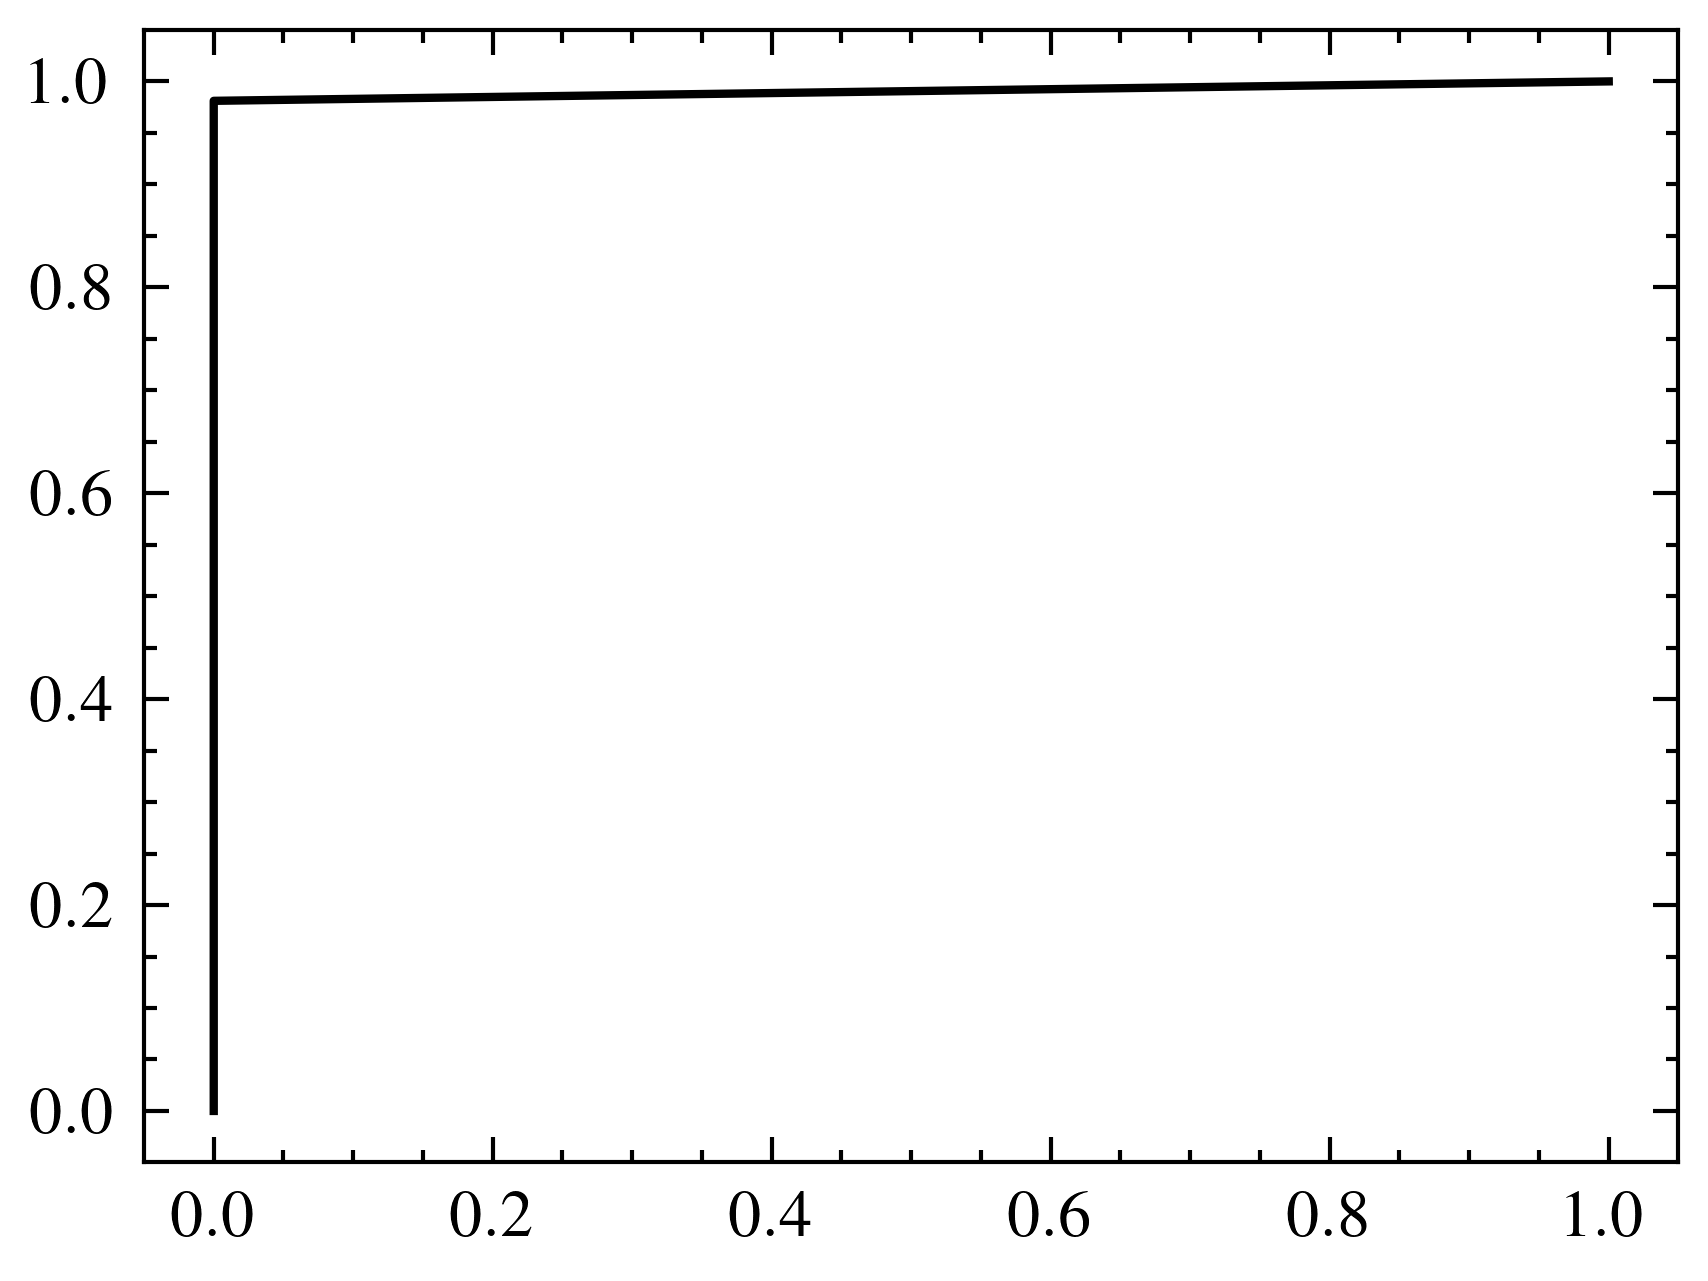

In [42]:
plt.plot(false_positive_rate, true_positive_rate)

In [44]:
test.to_csv('model_v3_test_df.csv')

In [49]:
svm_fpr,svm_tpr,thre = svm_train()

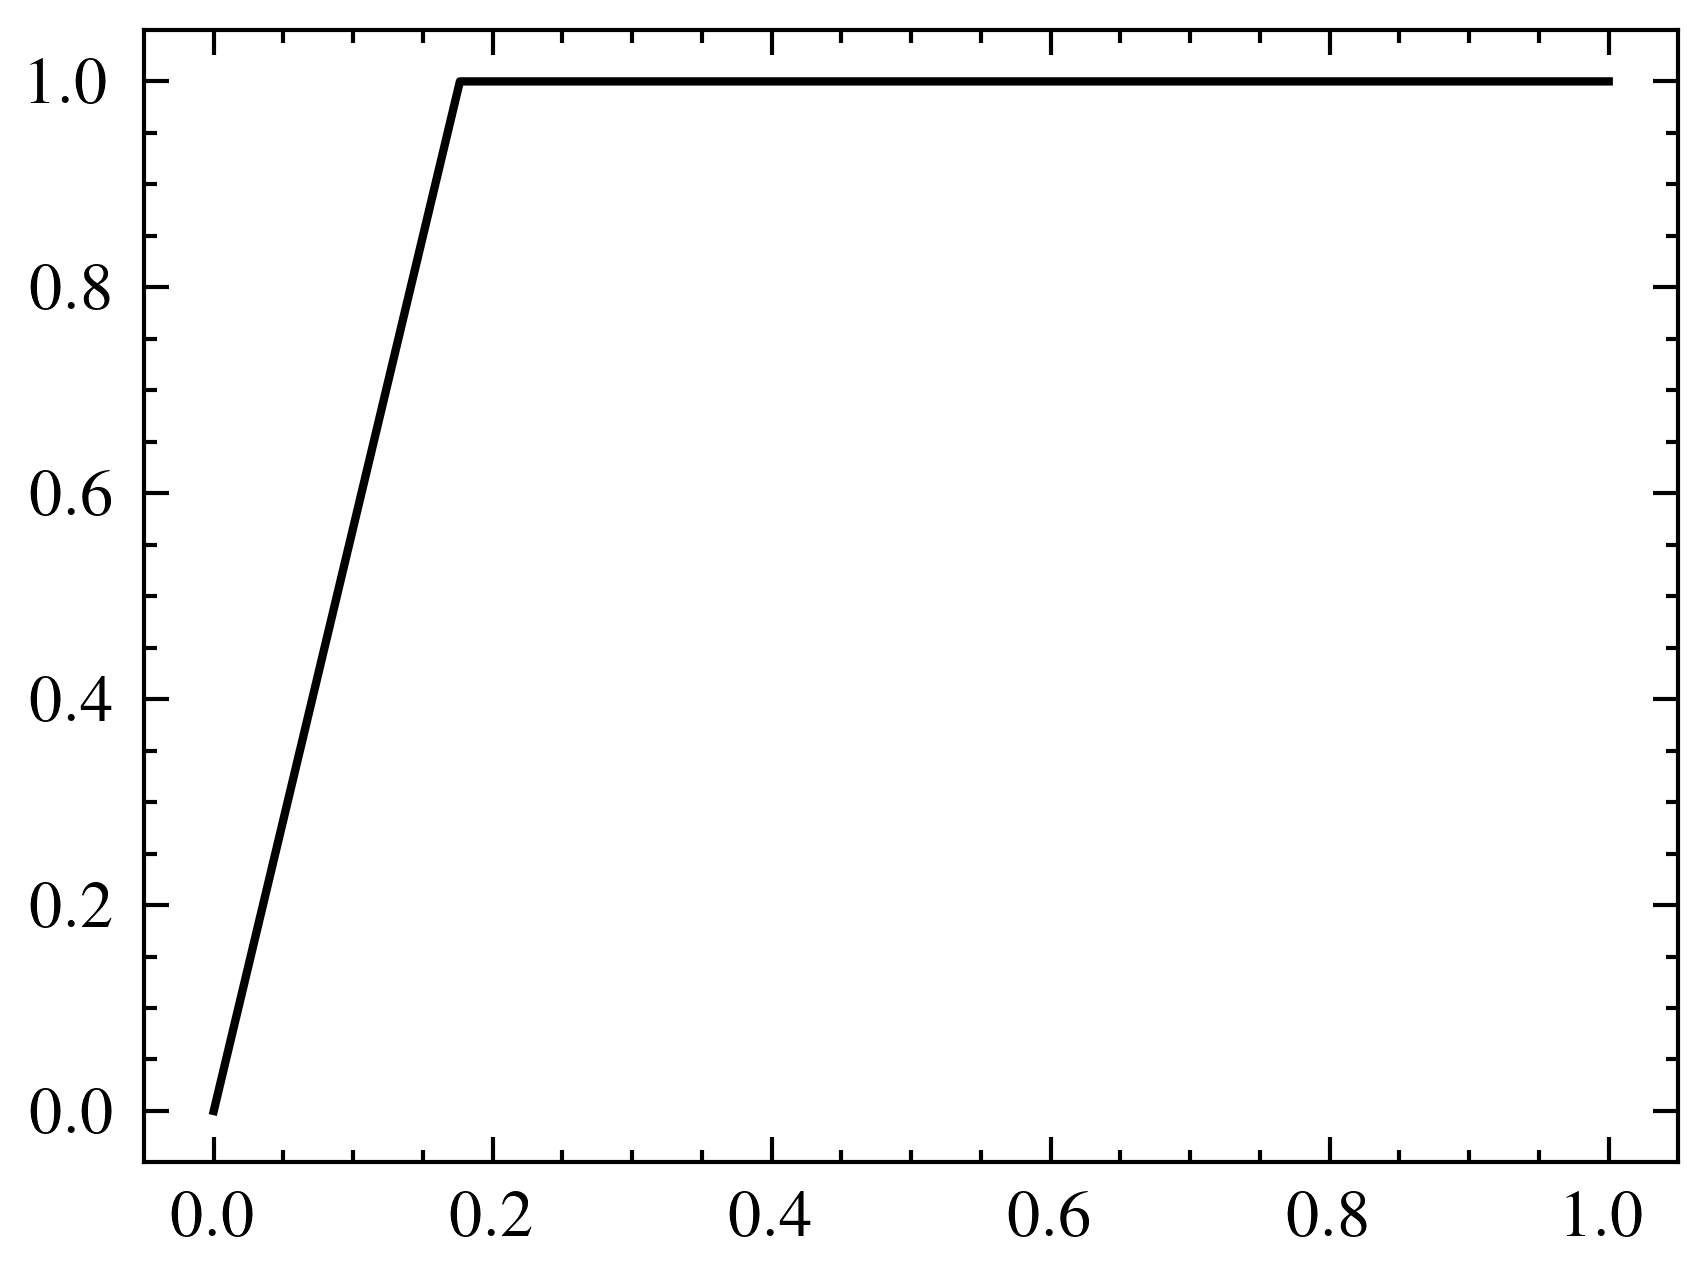

In [50]:
plt.plot(svm_fpr, svm_tpr)

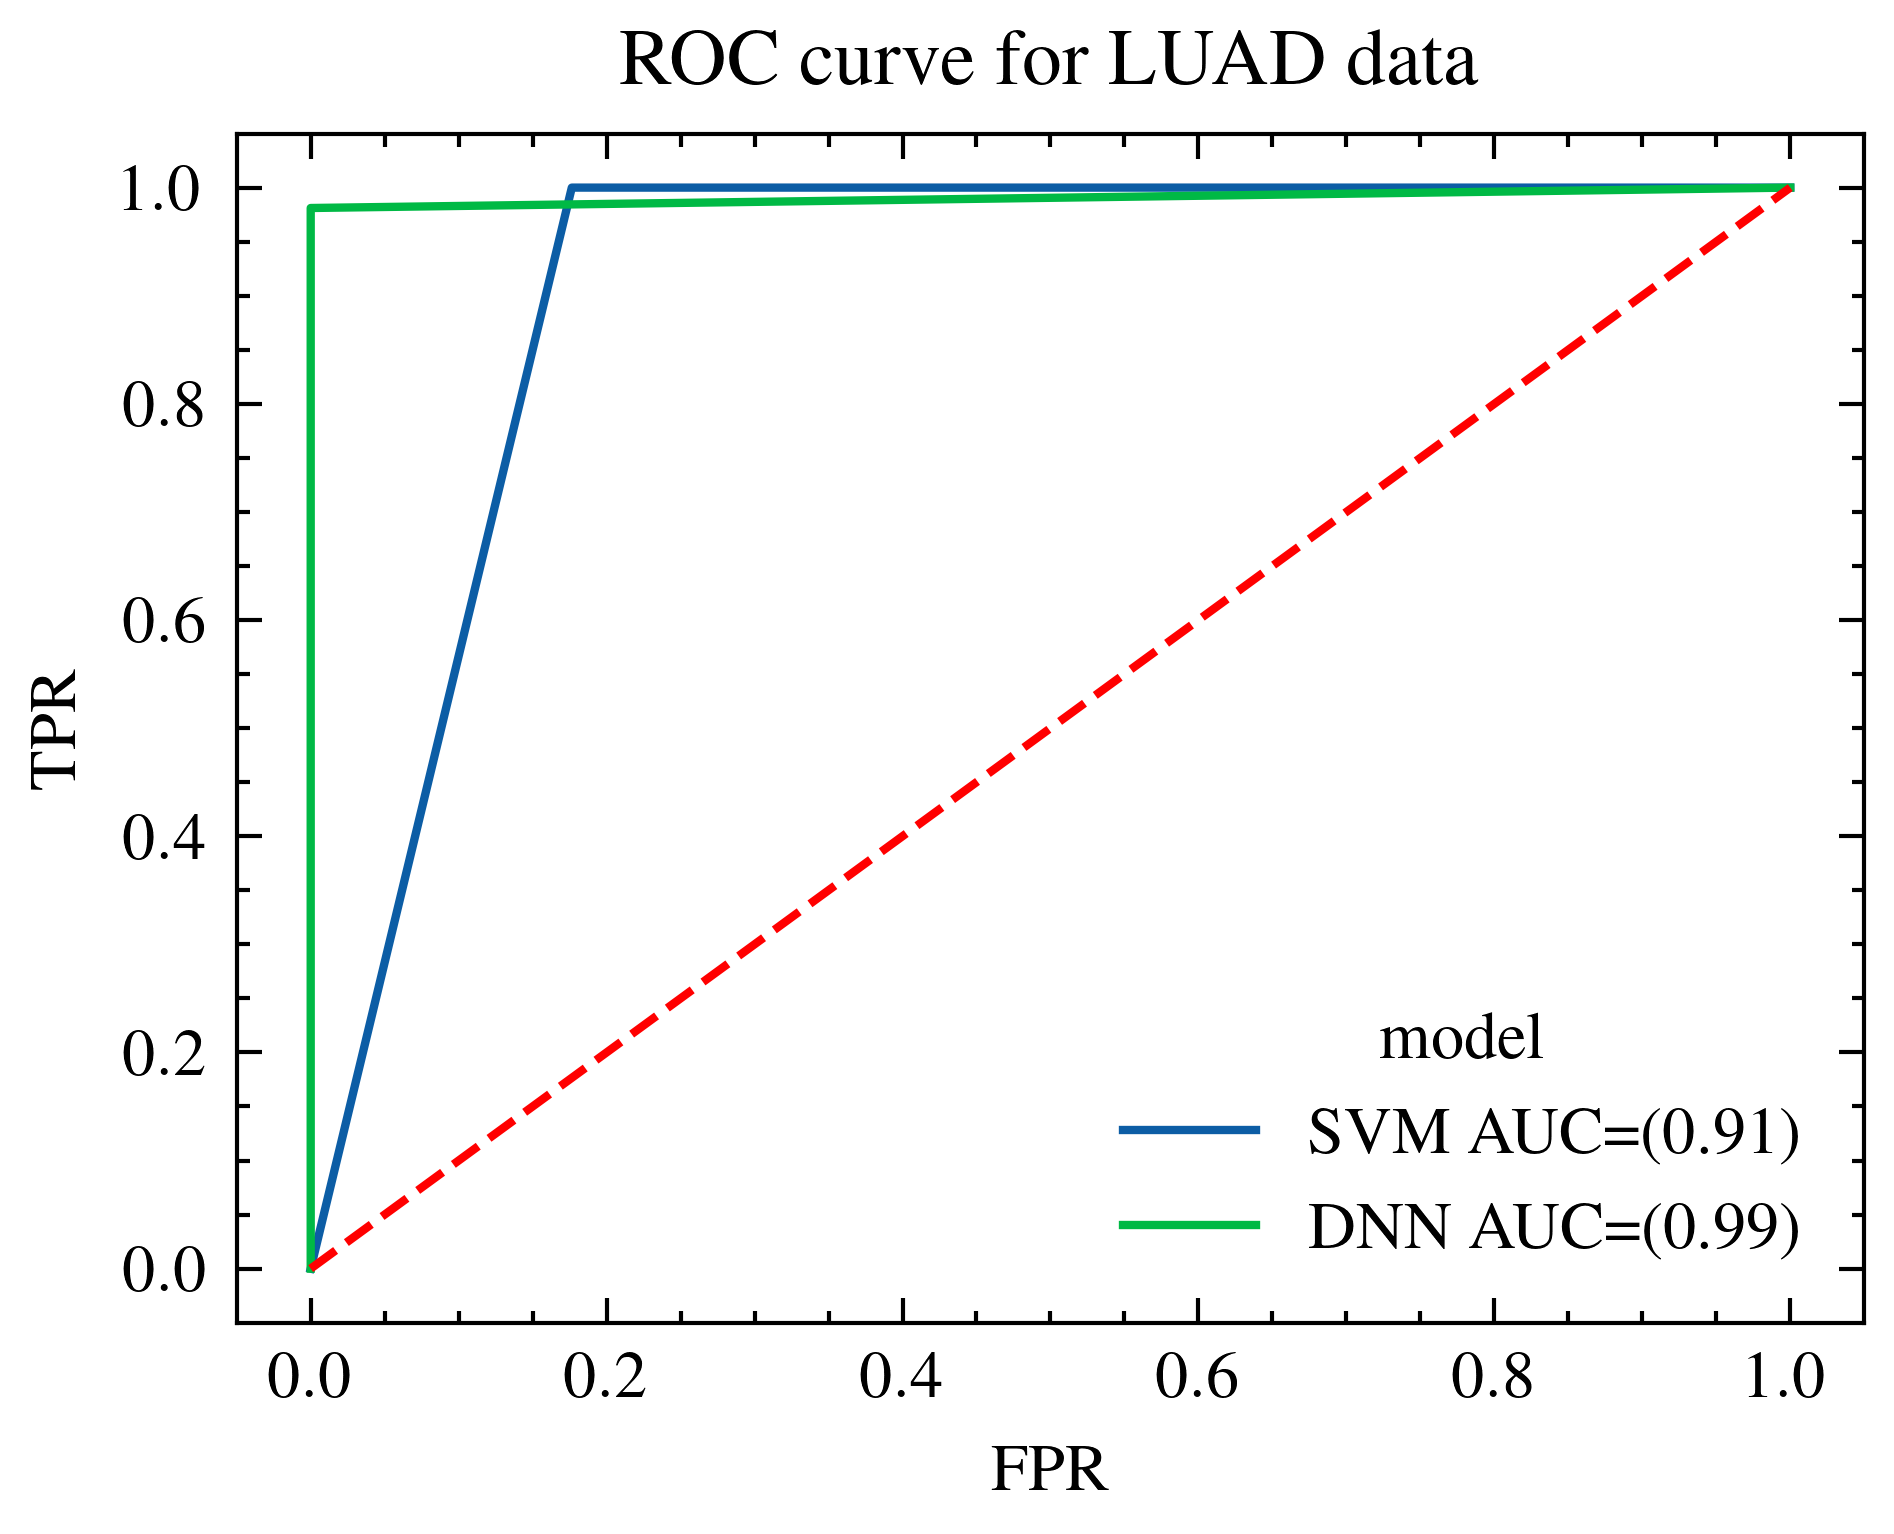

In [61]:

with plt.style.context(['science']):
    fig, ax = plt.subplots()        
    for p in ['SVM', 'DNN']: 
        fpr, tpr = get_ff(p)
        roc_auc=auc(fpr, tpr)
        ax.plot(fpr, tpr, label='%s AUC=(%.2f)' %(p, roc_auc)) 
    ax.plot([0,1],[0,1],'r--')
    ax.legend(loc='lower right') 
    ax.legend(title='model')       
    ax.set(xlabel='FPR')        
    ax.set(ylabel='TPR')
    plt.title('ROC curve for LUAD data')
    #ax.autoscale(tight=True)        
    #fig.savefig('fig1.pdf')        
    fig.savefig('fig1.jpg', dpi=300)

In [54]:
def get_ff(model_name):
    if model_name == 'SVM':
        return svm_fpr, svm_tpr
    if model_name == 'DNN':
        return false_positive_rate, true_positive_rate